# Analyze barcode correlation between replicates
Our main goal with the infections on 1-21-22 was to test which minimum library coverage still has good pairwise correlation between replicate infections, and check if there's bottlenecking at the RT steps. Some correlation analysis can be found in `notebooks/analyze_variant_counts.ipynb`, but this notebook follows up in more detail.

First, import Python modules:

In [1]:
import os

import altair as alt

import Bio.SeqIO

import dms_variants.codonvarianttable
import dms_variants.utils
import dms_variants.plotnine_themes

import scipy.stats

import pandas as pd

import yaml

from plotnine import *
_ = theme_set(dms_variants.plotnine_themes.theme_graygrid())

In [3]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

Change working directory to top directory of repo:

In [4]:
os.chdir('../../')

Read configuration:

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read the barcode counts and barcode runs:

In [6]:
barcode_runs = (
    pd.read_csv(config["barcode_runs"])
    .assign(antibody=lambda x: x["antibody"].fillna("no antibody"))
)

barcode_counts = pd.read_csv(config["barcode_counts"])

Read the parental gene sequence:

In [7]:
geneseq = str(Bio.SeqIO.read(config['gene_sequence_codon'], 'fasta').seq)
assert len(geneseq) % 3 == 0

Get the primary target:

In [8]:
primary_target = config["gene"]

## Create codon-variant table and add counts:
Create a [dms_variants codon-variant table](https://jbloomlab.github.io/dms_variants/codonvariant_sim_data.html):

In [9]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
    barcode_variant_file=config["virus_variants_w_neut_standard"],
    geneseq=geneseq,
    substitutions_are_codon=True,
    substitutions_col="codon_substitutions",
    allowgaps=True,
    primary_target=config["gene"],
)

Now add the sample counts:

In [10]:
variants.add_sample_counts_df(barcode_counts)

In [11]:
variant_counts = (
    variants.variant_count_df
    .query("target == @primary_target")
    [["library", "sample", "barcode", "count", "aa_substitutions"]]
    .merge(barcode_runs.drop(columns=["fastq_R1", "notes", "antibody_concentration"]))
    .assign(percent=lambda x: 100 * x["count"] / x.groupby("library_sample")["count"].transform("sum"))
    .sort_values(["library", "sample", "count"], ascending=[True, True, False])
)

Previous analysis indicated that a single outlier dominated variant counts, making up ~3% of the library variants. Make another version of `variant_counts` that removes this single outlier.

In [12]:
drop_top_n = 1

variant_counts_no_outlier = (variant_counts
                             .sort_values(["count"], ascending=[False])
                             .groupby('library_sample')
                             .apply(lambda group: group.iloc[drop_top_n:])
                            )

## Pairwise correlation between variant counts
Compute the pairwise correlations between variant counts for each library:

In [13]:
corrs = (
    dms_variants.utils.tidy_to_corr(
        df=variant_counts,
        sample_col="sample",
        label_col="barcode",
        value_col="count",
        group_cols=["library"],
    )
    .assign(r2=lambda x: x["correlation"]**2)
    .drop(columns="correlation")
    .sort_values(["library", "sample_1", "sample_2"])
)

# add other properties and flag samples that share these
suffixes = ["_1", "_2"]
cols_to_add =  ["antibody", "virus_batch", "sample_type", "date"]
for suffix in suffixes:
    corrs = (
        corrs.merge(
            barcode_runs[["library", "sample", *cols_to_add]],
            left_on=["library", f"sample{suffix}"],
            right_on=["library", "sample"],
            validate="many_to_one",
            suffixes=suffixes,
        )
        .drop(columns="sample")
    )
for col in cols_to_add:
    corrs = (
        corrs
        .assign(
            equal=lambda x: x[f"{col}_1"] == x[f"{col}_2"],
            **{col: lambda x: x[f"{col}_1"].where(x["equal"], pd.NA)},
        )
        .drop(columns=[f"{col}{suffix}" for suffix in suffixes])
    )

Plot on a log scale, to better resolve differences in pairwise correlations

In [14]:
corr_charts = []
for library, library_corr in corrs.groupby("library"):
    corr_chart = (
        alt.Chart(library_corr)
        .encode(
            alt.X("sample_1", title=None),
            alt.Y("sample_2", title=None),
            color=alt.Color("r2", scale=alt.Scale(type='log')),
            tooltip=[
                "library",
                "sample_1",
                "sample_2",
                alt.Tooltip("r2", format=".3f")
            ],
        )
        .mark_rect(stroke="black")
        .properties(width=alt.Step(15), height=alt.Step(15), title=library)
#         .add_selection(*selections)
    )
#     for selection in selections:
#         corr_chart = corr_chart.transform_filter(selection)
    corr_charts.append(corr_chart)

corr_chart = (
    alt.vconcat(*corr_charts)
    .configure_axis(labelLimit=500)

)

corr_chart

alt.VConcatChart(...)

Then try plotting again with the outlier removed

In [15]:
corrs = (
    dms_variants.utils.tidy_to_corr(
        df=variant_counts_no_outlier,
        sample_col="sample",
        label_col="barcode",
        value_col="count",
        group_cols=["library"],
    )
    .assign(r2=lambda x: x["correlation"]**2)
    .drop(columns="correlation")
    .sort_values(["library", "sample_1", "sample_2"])
)

# add other properties and flag samples that share these
suffixes = ["_1", "_2"]
cols_to_add =  ["antibody", "virus_batch", "sample_type", "date"]
for suffix in suffixes:
    corrs = (
        corrs.merge(
            barcode_runs[["library", "sample", *cols_to_add]],
            left_on=["library", f"sample{suffix}"],
            right_on=["library", "sample"],
            validate="many_to_one",
            suffixes=suffixes,
        )
        .drop(columns="sample")
    )
for col in cols_to_add:
    corrs = (
        corrs
        .assign(
            equal=lambda x: x[f"{col}_1"] == x[f"{col}_2"],
            **{col: lambda x: x[f"{col}_1"].where(x["equal"], pd.NA)},
        )
        .drop(columns=[f"{col}{suffix}" for suffix in suffixes])
    )

In [16]:
corr_charts = []
for library, library_corr in corrs.groupby("library"):
    corr_chart = (
        alt.Chart(library_corr)
        .encode(
            alt.X("sample_1", title=None),
            alt.Y("sample_2", title=None),
            color=alt.Color("r2", scale=alt.Scale(type='log')),
            tooltip=[
                "library",
                "sample_1",
                "sample_2",
                alt.Tooltip("r2", format=".3f")
            ],
        )
        .mark_rect(stroke="black")
        .properties(width=alt.Step(15), height=alt.Step(15), title=library)
#         .add_selection(*selections)
    )
#     for selection in selections:
#         corr_chart = corr_chart.transform_filter(selection)
    corr_charts.append(corr_chart)

corr_chart = (
    alt.vconcat(*corr_charts)
    .configure_axis(labelLimit=500)

)

corr_chart

alt.VConcatChart(...)

Removing the outlier didn't seem to make a huge impact on correlations - the r2 scale only dropped by ~0.01. 

These r2 values are surprisingly high, so we next want to look at individual scatterplots to confirm whether we are indeed getting good correlations. This could be skewed if, say, there are two populations of barcodes at low and high counts.

In [17]:
# add lib_coverage column for grouping
variant_counts_no_outlier['lib_coverage'] = variant_counts_no_outlier['replicate'].str.split('_').str[0]

In [18]:
def pivot_counts(df, coverage):
    counts_by_replicate = (
        df.loc[df['lib_coverage'] == coverage]
        .pivot(index='barcode', columns='replicate', values='count')
        .reset_index()
        .rename_axis(None, axis=1)
    )
    
    return counts_by_replicate


def plot_correlates(df, coverage, replicate_pairs, figs_dir):
    
    for pair in replicate_pairs:
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
            df[f'{coverage}_{pair[0]}'], df[f'{coverage}_{pair[1]}'])
        
        r2 = r_value**2

        p = (
            ggplot(
            df,
            aes(x=f'{coverage}_{pair[0]}', y=f'{coverage}_{pair[1]}')) + 
        geom_point() + 
        annotate('text', 
                 x=((df[f'{coverage}_{pair[0]}'].max())*0.16), 
                 y=((df[f'{coverage}_{pair[1]}'].max())*0.9), 
                 label=f'r2={str(r2)[0:5]}', size=10) +
        theme(figure_size=(3, 3),
             panel_grid_major_x=element_blank(),
             ))
        
        plotfile = os.path.join(figs_dir, f"{coverage}_{pair[0]}_{pair[1]}_corr.png")
        print(f'saving plot to {plotfile}')
        p.save(plotfile, verbose=False)

        _ = p.draw()
        

saving plot to experiments/infections/220121_correlations/25x_1_2_rt1_corr.png
saving plot to experiments/infections/220121_correlations/25x_2_rt2_2_rt1_corr.png
saving plot to experiments/infections/220121_correlations/50x_1_2_rt1_corr.png
saving plot to experiments/infections/220121_correlations/50x_2_rt2_2_rt1_corr.png
saving plot to experiments/infections/220121_correlations/100x_1_2_rt1_corr.png
saving plot to experiments/infections/220121_correlations/100x_2_rt2_2_rt1_corr.png


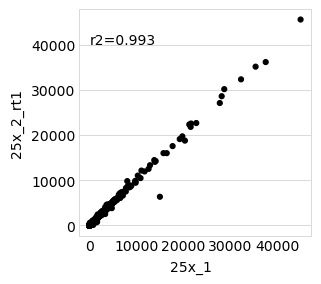

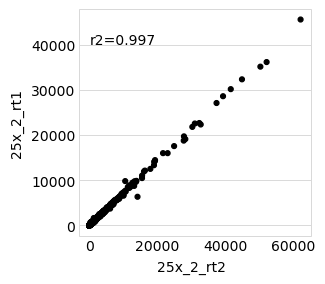

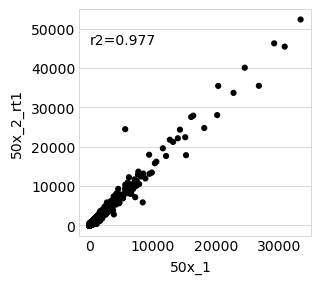

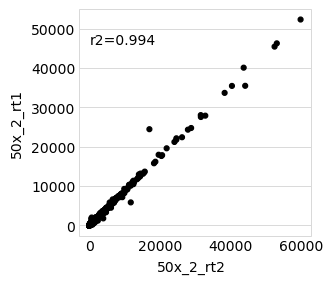

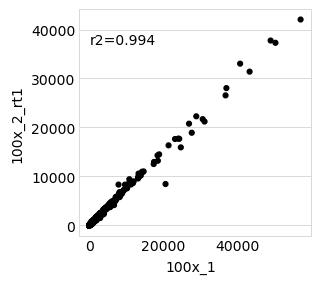

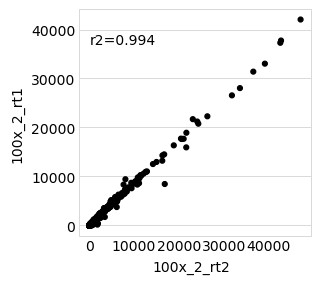

In [19]:
figs_dir = 'experiments/infections/220121_correlations'
conditions = ['25x', '50x', '100x']
replicate_pairs = [['1','2_rt1'], ['2_rt2', '2_rt1']]

for coverage in conditions:
    counts_by_replicate = pivot_counts(variant_counts_no_outlier, coverage)
    plot_correlates(counts_by_replicate, coverage, replicate_pairs, figs_dir)

Correlations look great! Note that cells were infected at an MOI of 5, under no selection conditions, so maybe it's expected that we have very little noise between replicates. But this is a promising start.